# ISSP 2160 Assignment 4 

In [78]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os
import numpy as np
import pandas as pd

# use absolute path to ensure autoload works after chdir
sys.path.append('/net/pulsar/home/koes/mtr22/param_search')
import param_search

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Problem 1 - Genetic algorithm

In [6]:
os.chdir('/net/pulsar/home/koes/mtr22/ISSP2160/assignment-4/TSP')

# create a template job script
template_file = 'GA.sh'
template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH -p dept_gpu
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
{job_params}
python3 ../GA.py \\
    --n_population {n_population} \\
    --n_generations {n_generations} \\
    --mutate_prob {mutate_prob} \\
    --cull_pct {cull_pct} \\
    --elite_pct {elite_pct} \\
    --no_plot \\
    --random_seed {random_seed} \\
    --out_file $SLURM_JOB_ID.metrics

'''
with open(template_file, 'w') as f:
    f.write(template)
print(template, end='')

#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH -p dept_gpu
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
{job_params}
python3 ../GA.py \
    --n_population {n_population} \
    --n_generations {n_generations} \
    --mutate_prob {mutate_prob} \
    --cull_pct {cull_pct} \
    --elite_pct {elite_pct} \
    --no_plot \
    --random_seed {random_seed} \
    --out_file $SLURM_JOB_ID.metrics



In [7]:
# define the default parameters
default_params = param_search.ParamSpace(
    part=None,
    n_generations=500,
    n_population=500,
    mutate_prob=0.05,
    cull_pct=0.05,
    elite_pct=0.05,
    random_seed=range(10),
)

# create the param spaces for parts a-e

a_params = default_params.copy()
a_params['part'] = 'a'
a_params['n_generations'] = range(200, 1001, 100)

b_params = default_params.copy()
b_params['part'] = 'b'
b_params['n_population'] = range(250, 751, 50)

c_params = default_params.copy()
c_params['part'] = 'c'
c_params['mutate_prob'] = np.arange(0.00, 0.26, 0.05)

d_params = default_params.copy()
d_params['part'] = 'd'
d_params['cull_pct'] = np.arange(0.00, 0.26, 0.05)

e_params = default_params.copy()
e_params['part'] = 'e'
e_params['elite_pct'] = np.arange(0.00, 0.26, 0.05)

param_space = (
    a_params +
    b_params +
    c_params +
    d_params +
    e_params
)

len(param_space)

380

In [8]:
# setup parameterized job scripts
job_files = param_search.setup(
    expt_dir=os.getcwd(),
    name_format='ga{part}_{n_generations}_{n_population}_{mutate_prob:.2f}_{cull_pct:.2f}_{elite_pct:.2f}_{random_seed}',
    template_file=template_file,
    param_space=param_space
)

In [ ]:
# submit jobs to the cluster
job_ids = param_search.submit(job_files)

In [ ]:
# monitor job status
param_search.status(job=job_ids).set_index('job_id')

In [ ]:
# check jobs for errors
any(param_search.job_output.get_job_errors(job_files))

In [9]:
# read output metrics
metrics = param_search.metrics(job_files)

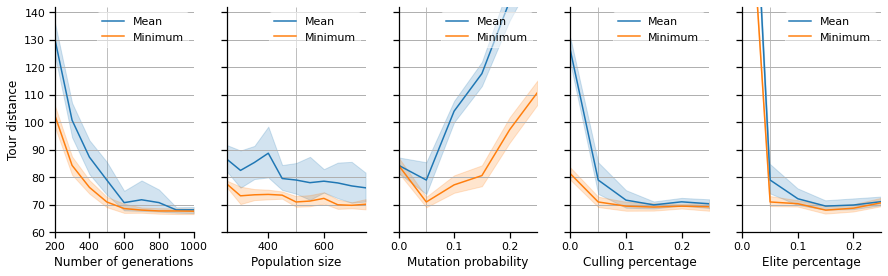

In [77]:
import seaborn as sns
sns.set_context('notebook')

def my_plot(data, x, y, ax, **kwargs):
    sns.lineplot(data=data[data.part == part_map[x]], x=x, y=y, ax=ax, **kwargs)
    y_min, y_max = 60, 142 #ax.get_ylim()
    ax.vlines(default_params[x], y_min, y_max, color='k', alpha=0.25, linewidth=1, zorder=-100)
    ax.set_ylim(y_min, y_max)
    ax.grid(axis='y')
    ax.set_xlabel(label_map[x])
    ax.set_ylabel(label_map[y])
    ax.set_xlim(data[x].min(), data[x].max())
    
label_map = {
    'n_generations': 'Number of generations',
    'n_population': 'Population size',
    'mutate_prob': 'Mutation probability',
    'cull_pct': 'Culling percentage',
    'elite_pct': 'Elite percentage',
    'fitness': 'Tour distance',
    'mean_fitness': 'Mean',
    'min_fitness': 'Minimum'
}

part_map = {
    'n_generations': 'a',
    'n_population': 'b',
    'mutate_prob': 'c',
    'cull_pct': 'd',
    'elite_pct': 'e',
}

y = ['mean_fitness', 'min_fitness']
last_metrics = metrics.groupby(list(default_params.keys())).last()
last_metrics.columns.name = 'metric'
last_metrics = pd.DataFrame(dict(fitness=last_metrics[y].stack(0))).reset_index().set_index(list(default_params.keys()))
last_metrics['metric'] = last_metrics['metric'].map(label_map.__getitem__)

fig = param_search.results.plot(
    last_metrics,
    y='fitness',d
    x=['n_generations', 'n_population', 'mutate_prob', 'cull_pct', 'elite_pct'],
    hue='metric',
    plot_func=my_plot,
    n_cols=5,
    height=4,
    width=2.5,
    legend_kws=dict(title=False, bbox_to_anchor=None, loc=None, frameon=True, edgecolor='w', framealpha=0.5),
    tight=True,
    sharey=True,
)
fig.savefig('GA_stats.pdf', bbox_inches='tight', dpi=400)

## Problem 3 - Tic-tac-toe-10 player

In [262]:
os.chdir('/net/pulsar/home/koes/mtr22/ISSP2160/assignment-4/tictactoe')

# create a template job script
template_file = 'main.sh'
template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH -p dept_cpu
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
{job_params}
python3 ../main.py \\
    --board_size 10 \\
    --A_heuristic {A_heuristic} \\
    --B_heuristic {B_heuristic} \\
    --A_k_ply {A_k_ply} \\
    --B_k_ply {B_k_ply} \\
    --n_A_starts {n_A_starts} \\
    --n_B_starts {n_B_starts} \\
    --random_seed {random_seed} \\
    --out_file outcome.metrics

'''
with open(template_file, 'w') as f:
    f.write(template)
print(template, end='')

#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH -p dept_cpu
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
{job_params}
python3 ../main.py \
    --board_size 10 \
    --A_heuristic {A_heuristic} \
    --B_heuristic {B_heuristic} \
    --A_k_ply {A_k_ply} \
    --B_k_ply {B_k_ply} \
    --n_A_starts {n_A_starts} \
    --n_B_starts {n_B_starts} \
    --random_seed {random_seed} \
    --out_file outcome.metrics



In [263]:
default_params = param_search.ParamSpace(
    part=None,
    A_heuristic='basic',
    B_heuristic='basic',
    A_k_ply=2,
    B_k_ply=2,
)

equal_starts = param_search.ParamSpace(
    n_A_starts=1,
    n_B_starts=0,
    random_seed=range(0, 5)
) + param_search.ParamSpace(
    n_A_starts=0,
    n_B_starts=1,
    random_seed=range(5, 10)
)

A_always_starts = param_search.ParamSpace(
    n_A_starts=1,
    n_B_starts=0,
    random_seed=range(10)
)

a_params = default_params.copy()
a_params['part'] = 'a'
a_params['B_heuristic'] = 'naive'
a_params *= equal_starts

b_params = default_params.copy()
b_params['part'] = 'b'
b_params *= A_always_starts

c_params = default_params.copy()
c_params['part'] = 'c'
c_params['B_k_ply'] = 1
c_params *= equal_starts

d_params = default_params.copy()
d_params['part'] = 'd'
d_params['B_heuristic'] = 'my'
d_params *= equal_starts

param_space = (
    a_params +
    b_params +
    c_params +
    d_params
)

len(param_space)

40

In [264]:
# setup parameterized job scripts
job_files = param_search.setup(
    expt_dir=os.getcwd(),
    name_format='ttt{part}_{random_seed}',
    template_file=template_file,
    param_space=param_space
)

In [265]:
# submit jobs to the cluster
job_ids = param_search.submit(job_files)

In [269]:
# monitor job status
param_search.status(job=job_ids).set_index('job_id')

,queue,job_name,user,job_state,runtime,walltime,node_id,work_dir,array_idx
job_id,,,,,,,,,


In [270]:
# check jobs for errors
any(param_search.errors(job_files))

........................................

False

In [271]:
# read output metrics
metrics = param_search.metrics(job_files, quotechar="'")

In [272]:
metrics.groupby(['part', 'outcome'])[['game_idx']].count()

game_idx
part outcome           
a    Player A         9
     Tie              1
b    Player A         1
     Player B         1
     Tie              8
c    Player A        10
d    Player B         4
     Tie              6